In [2]:
%matplotlib inline

In [3]:
!pip install -q pycaret
!pip install -q lazypredict
!pip install -q featurewiz
!pip install -q autofeat
!pip install -q -U ydata-profiling

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydocstyle 6.3.0 requires importlib-metadata<5.0.0,>=2.0.0; python_version < "3.8", but you have importlib-metadata 6.3.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 6.3.0 which is incompatible.
flake8 5.0.4 requires importlib-metadata<4.3,>=1.1.0; python_version < "3.8", but you have importlib-metadata 6.3.0 which is incompatible.
cmudict 1.0.13 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.3.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pycaret.classification import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [5]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
train_df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [6]:
train_df.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


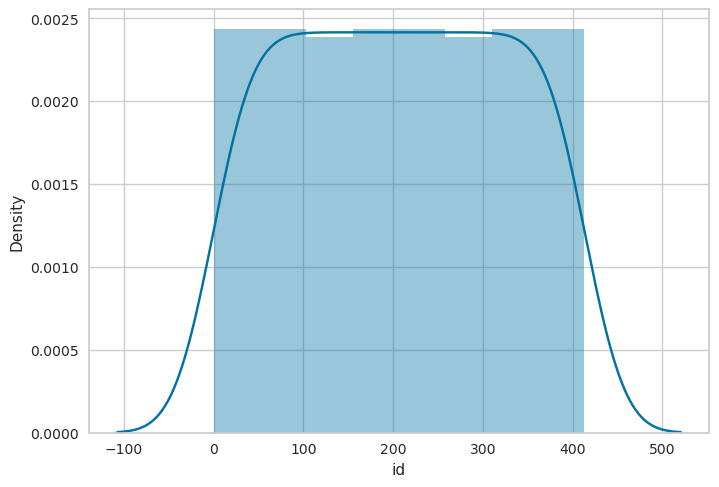

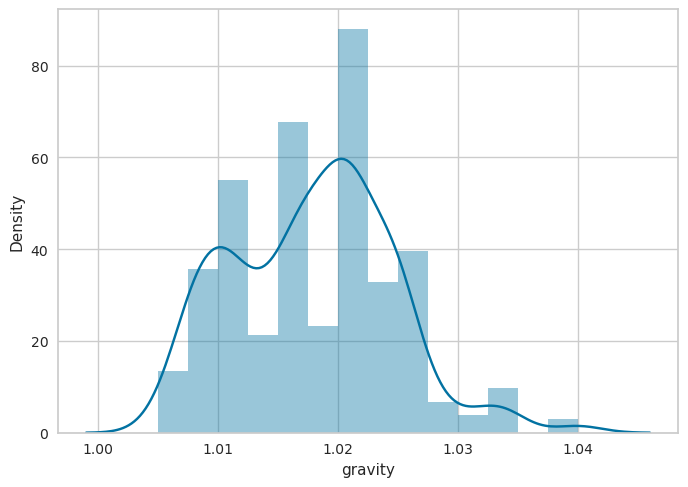

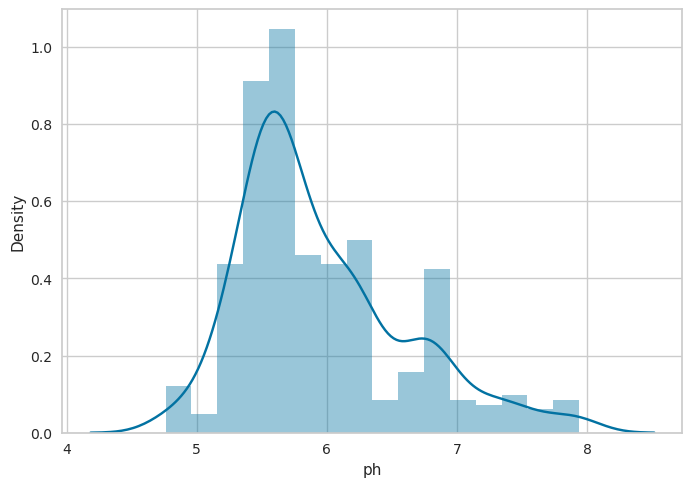

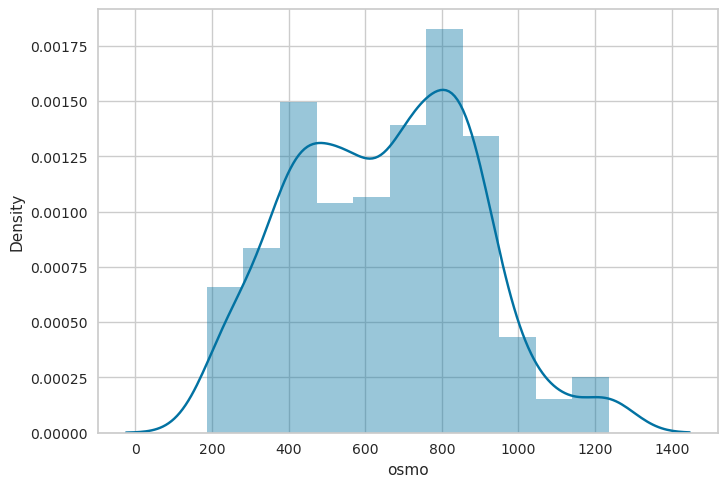

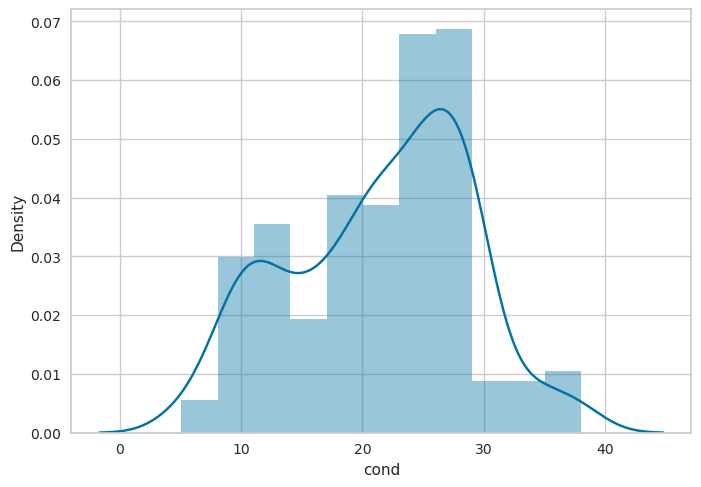

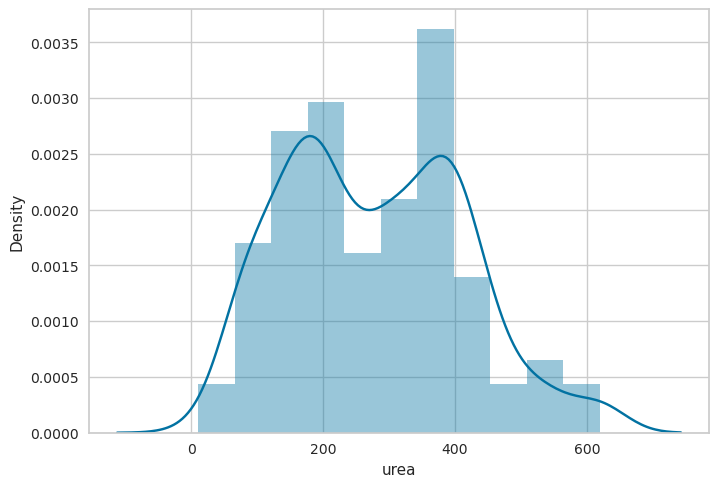

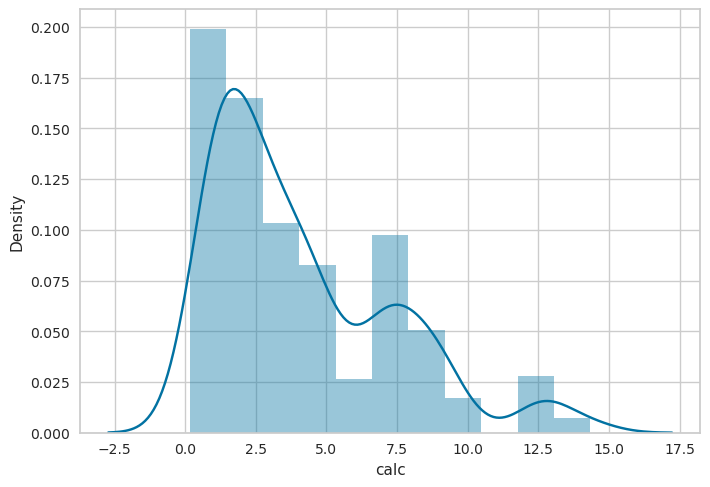

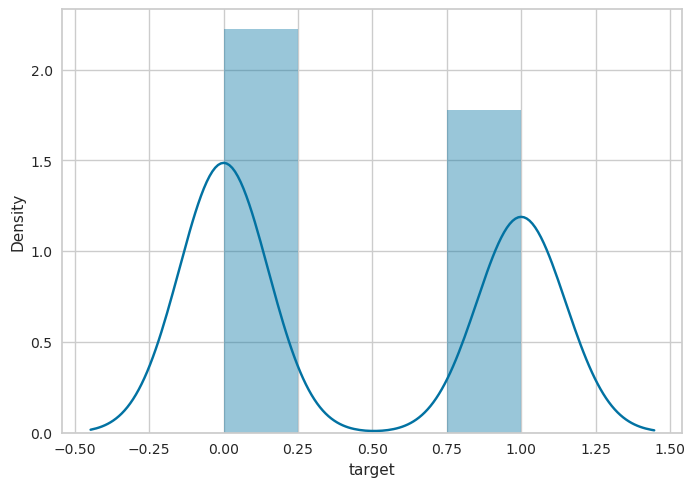

In [7]:
import seaborn as sns
for col in train_df.columns:
    sns.distplot(train_df[col])
    plt.show()

Berdasarkan Grafik ini:
* gravity cenderung memiliki distribusi bimodal
* ph cenderung memiliki positive skewness
* osmo memiliki distribusi bimodal
* urea memiliki distribusi bimodal
* calc memiliki memiliki positive skewness

In [8]:
from ydata_profiling import ProfileReport
profiling_df = ProfileReport(train_df,title="Kidney Stone",explorative=True)
profiling_df.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
from autofeat import *
from sklearn.model_selection import train_test_split
model_auto = AutoFeatClassifier(feateng_steps=3,
                                verbose=10)

X = train_df.drop(['id','target'],axis=1)
y = train_df.target
x_df = model_auto.fit_transform(X,y)

[AutoFeat] The 3 step feature engineering process could generate up to 21567 features.
[AutoFeat] With 414 data points this new feature matrix would use about 0.04 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 32 transformed features from 6 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 2711 feature combinations from 703 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 11397 transformed features from 2711 original features - done.
[feateng] Generated altogether 15206 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 5890 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel]	 0 initial features.
[featsel]	 Split 24/24: 282 candidate features identified.
[featsel]	 Selected  10 features after noise filtering.
[featsel] Fea

Ca<sup>2+</sup> + C<sub>2</sub>O<sub>4</sub><sup>2-</sup> &rarr; CaC<sub>2</sub>O<sub>4</sub>

In [20]:
train_df_auto = pd.merge(x_df,y,left_index=True,right_index=True)
train_df_auto

,gravity,ph,osmo,cond,urea,calc,Abs(ph*log(calc)),1/(log(calc) + 1/ph),target
0,1.013,6.19,443.0,14.8,124.0,1.45,2.299978,1.875770,0
1,1.025,5.40,703.0,23.6,394.0,4.18,7.723681,0.619005,0
2,1.009,6.13,371.0,24.5,159.0,9.04,13.496171,0.422870,0
3,1.021,4.91,442.0,20.8,398.0,6.63,9.287780,0.477265,1
4,1.021,5.53,874.0,17.8,385.0,2.21,4.385249,1.026879,1
...,...,...,...,...,...,...,...,...,...
409,1.011,5.21,527.0,21.4,75.0,1.53,2.215645,1.620204,0
410,1.024,5.53,577.0,19.7,224.0,0.77,1.445347,-12.417280,0
411,1.018,6.28,455.0,22.2,270.0,7.68,12.802531,0.454989,1
412,1.008,7.12,325.0,12.6,75.0,1.03,0.210459,5.882068,1


In [21]:
train_df_auto = pd.merge(train_df_auto,train_df.id,left_index=True,right_index=True)
train_df_auto

,gravity,ph,osmo,cond,urea,calc,Abs(ph*log(calc)),1/(log(calc) + 1/ph),target,id
0,1.013,6.19,443.0,14.8,124.0,1.45,2.299978,1.875770,0,0
1,1.025,5.40,703.0,23.6,394.0,4.18,7.723681,0.619005,0,1
2,1.009,6.13,371.0,24.5,159.0,9.04,13.496171,0.422870,0,2
3,1.021,4.91,442.0,20.8,398.0,6.63,9.287780,0.477265,1,3
4,1.021,5.53,874.0,17.8,385.0,2.21,4.385249,1.026879,1,4
...,...,...,...,...,...,...,...,...,...,...
409,1.011,5.21,527.0,21.4,75.0,1.53,2.215645,1.620204,0,409
410,1.024,5.53,577.0,19.7,224.0,0.77,1.445347,-12.417280,0,410
411,1.018,6.28,455.0,22.2,270.0,7.68,12.802531,0.454989,1,411
412,1.008,7.12,325.0,12.6,75.0,1.03,0.210459,5.882068,1,412


* Abs(ph*log(calc))
* 1/(log(calc) + 1/ph)

Disini secara tidak langsung, bahwa ph dapat mempengaruhi kesetimbangan reaksi tersebut secara tidak langsung

In [22]:
train_df_auto.columns = ['gravity','ph','osmo','cond','urea','calc','eng1','eng2','target','id']
train_df_auto = train_df_auto[['id','gravity','ph','osmo','cond','urea','calc','eng1','eng2','target']]
train_df_auto.head()

,id,gravity,ph,osmo,cond,urea,calc,eng1,eng2,target
0,0,1.013,6.19,443.0,14.8,124.0,1.45,2.299978,1.875770,0
1,1,1.025,5.40,703.0,23.6,394.0,4.18,7.723681,0.619005,0
2,2,1.009,6.13,371.0,24.5,159.0,9.04,13.496171,0.422870,0
3,3,1.021,4.91,442.0,20.8,398.0,6.63,9.287780,0.477265,1
4,4,1.021,5.53,874.0,17.8,385.0,2.21,4.385249,1.026879,1


train_df_auto.columns = ['gravity','ph','osmo','cond','urea','calc','Abs(ph*log(calc))','1/(log(calc) + 1/ph)','target']

In [23]:
clex = ClassificationExperiment()
clex.setup(data=train_df_auto,
           target='target',
           # transformation=True,
           ignore_features=['id'],
           # transformation_method='quantile',
           # polynomial_features=True,
           # remove_outliers=True,
           # fix_imbalance=True,
           session_id=42)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(414, 10)"
4,Transformed data shape,"(399, 9)"
5,Transformed train set shape,"(274, 9)"
6,Transformed test set shape,"(125, 9)"
7,Ignore features,1
8,Numeric features,8
9,Preprocess,True


In [24]:
model_clas = ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp',
              'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost',
              'lightgbm', 'catboost', 'dummy']
model_cla = clex.compare_models(include=model_clas,sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7548,0.8138,0.7128,0.7387,0.7185,0.5031,0.5106,0.6580
rbfsvm,SVM - Radial Kernel,0.7305,0.8116,0.6423,0.7349,0.6787,0.4500,0.4594,0.0660
lda,Linear Discriminant Analysis,0.7583,0.8104,0.7058,0.7447,0.7177,0.5083,0.5163,0.0570
nb,Naive Bayes,0.7302,0.7932,0.7436,0.6868,0.7075,0.4593,0.4682,0.0680
catboost,CatBoost Classifier,0.7304,0.7886,0.6885,0.7054,0.6903,0.4533,0.4580,1.8830
rf,Random Forest Classifier,0.7304,0.7835,0.6724,0.7105,0.6861,0.4518,0.4562,0.3110
gpc,Gaussian Process Classifier,0.7201,0.7806,0.6583,0.7050,0.6721,0.4310,0.4394,0.2740
et,Extra Trees Classifier,0.7063,0.7773,0.6186,0.6955,0.6490,0.3995,0.4052,0.3120
knn,K Neighbors Classifier,0.7337,0.7707,0.7192,0.7057,0.7054,0.4644,0.4710,0.1120
mlp,MLP Classifier,0.6995,0.7698,0.6417,0.6834,0.6555,0.3911,0.3958,0.4360


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [25]:
tuned_model_cla = clex.tune_model(model_cla,optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7931,0.8558,0.7692,0.7692,0.7692,0.5817,0.5817
1,0.6552,0.7692,0.8462,0.5789,0.6875,0.3318,0.3622
2,0.7931,0.8510,0.8462,0.7333,0.7857,0.5877,0.5933
3,0.6552,0.7356,0.6154,0.6154,0.6154,0.3029,0.3029
4,0.7931,0.8606,0.6923,0.8182,0.7500,0.5756,0.5815
5,0.7586,0.8798,0.7692,0.7143,0.7407,0.5155,0.5168
6,0.6207,0.6635,0.4615,0.6000,0.5217,0.2162,0.2213
7,0.7931,0.8702,0.6923,0.8182,0.7500,0.5756,0.5815
8,0.6897,0.7451,0.9167,0.5789,0.7097,0.4108,0.4622


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [26]:
cal_tuned_model_cla = clex.calibrate_model(tuned_model_cla)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8276,0.8558,0.7692,0.8333,0.8000,0.6489,0.6505
1,0.7241,0.7692,0.8462,0.6471,0.7333,0.4579,0.4758
2,0.7241,0.8510,0.6154,0.7273,0.6667,0.4341,0.4386
3,0.6552,0.7356,0.6154,0.6154,0.6154,0.3029,0.3029
4,0.7931,0.8510,0.6154,0.8889,0.7273,0.5693,0.5943
5,0.8276,0.8798,0.7692,0.8333,0.8000,0.6489,0.6505
6,0.5862,0.6587,0.3846,0.5556,0.4545,0.1386,0.1447
7,0.7931,0.8654,0.6923,0.8182,0.7500,0.5756,0.5815
8,0.7586,0.7500,0.9167,0.6471,0.7586,0.5312,0.5637


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
final_model_cla = clex.finalize_model(cal_tuned_model_cla)

In [28]:
test_df['eng1'] = abs(test_df['ph'] + np.log(test_df['calc']))
test_df['eng2'] = 1/(np.log(test_df['calc']) + (1/(test_df['ph'])))
test_df

,id,gravity,ph,osmo,cond,urea,calc,eng1,eng2
0,414,1.017,5.24,345,11.5,152,1.16,5.388420,2.947594
1,415,1.020,5.68,874,29.0,385,3.46,6.921269,0.705555
2,416,1.024,5.36,698,19.5,354,13.00,7.924949,0.363436
3,417,1.020,5.33,668,25.3,252,3.46,6.571269,0.699846
4,418,1.011,5.87,567,29.0,457,2.36,6.728662,0.971799
...,...,...,...,...,...,...,...,...,...
271,685,1.029,6.27,853,21.4,364,7.31,8.259243,0.465391
272,686,1.012,5.62,410,14.0,195,1.45,5.991564,1.819838
273,687,1.031,5.68,874,29.0,380,4.49,7.181853,0.595980
274,688,1.019,5.47,543,21.4,170,1.64,5.964696,1.475989


In [29]:
hasil_df = clex.predict_model(final_model_cla,data=test_df)
hasil_df.head(10)

,id,gravity,ph,osmo,cond,urea,calc,eng1,eng2,prediction_label,prediction_score
0,414,1.017,5.24,345,11.500000,152,1.16,5.388420,2.947594,0,0.6830
1,415,1.020,5.68,874,29.000000,385,3.46,6.921268,0.705554,0,0.5415
2,416,1.024,5.36,698,19.500000,354,13.00,7.924949,0.363436,1,0.5849
3,417,1.020,5.33,668,25.299999,252,3.46,6.571269,0.699846,0,0.5794
4,418,1.011,5.87,567,29.000000,457,2.36,6.728662,0.971799,0,0.5702
5,419,1.023,5.77,749,20.000000,385,4.49,7.271852,0.596957,1,0.5196
6,420,1.015,5.94,461,17.400000,195,3.93,7.308640,0.650622,0,0.5513
7,421,1.024,5.53,1236,29.000000,620,12.68,8.070026,0.367531,1,0.6010
8,422,1.010,6.79,242,11.200000,64,0.65,6.359217,-3.527243,0,0.7280
9,423,1.005,7.20,541,17.799999,195,1.03,7.229559,5.936561,0,0.7764


In [30]:
hasil_df = hasil_df[['id','prediction_label']]
hasil_df.columns = [['id','target']]
hasil_df.to_csv('coba.csv',index=False)

In [32]:
from ydata_profiling import ProfileReport
profiling_df = ProfileReport(train_df_auto,title="Kidney Stone",explorative=True)
profiling_df.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]